
# Simulazione di politiche di similarity caching

In [1]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
from PromptDatasetManager import PromptDatasetManager
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=5000 # Limita per testare velocemente
)
print(f"Colonne disponibili: {list(manager.df.columns)}")

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']


## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

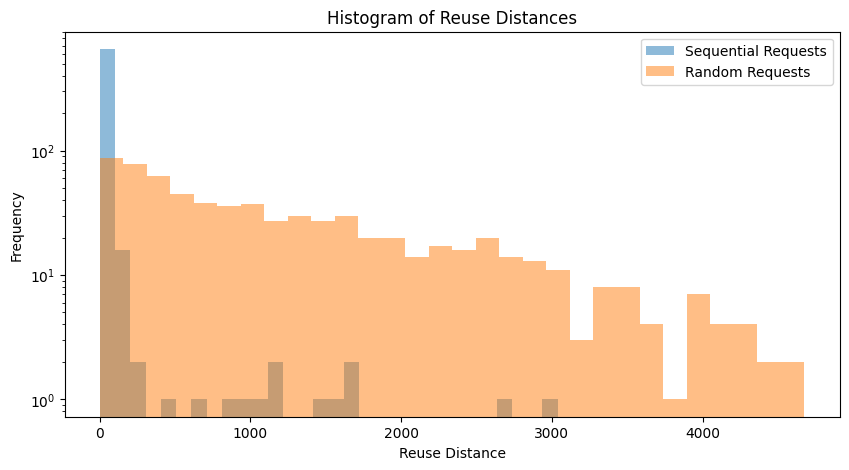

In [3]:

def compute_reuse_dist(requests: List[str]) -> List[int]:
    last = {}
    deltas = []
    for i, p in enumerate(requests):
        if p in last:
            deltas.append(i - last[p])
        last[p] = i
    return deltas

seq_requests = manager.sample_prompts(num_prompts=None, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=None, random_order=True)

reuse_seq = compute_reuse_dist([p for p,_ in seq_requests])
reuse_rand = compute_reuse_dist([p for p,_ in rand_requests])

# Plot histogram of reuse distances (log scale)
plt.figure(figsize=(10, 5))
plt.hist(reuse_seq, bins=30, alpha=0.5, label='Sequential Requests', log=True)
plt.hist(reuse_rand, bins=30, alpha=0.5, label='Random Requests', log=True)
plt.title('Histogram of Reuse Distances')
plt.xlabel('Reuse Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [4]:
import Dashboard as ds
from CachePolicy import LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache, TwoLRUCache

In [5]:

caching_policies = [LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache, TwoLRUCache]

dim = manager.emb_matrix.shape[1]
dashboard = ds.get_dashboard(manager, caching_policies, num_requests=5000, dim=dim)
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'8cdde54e-a58c-409e-99f9-c5f1c7ff1392': {'version…

### Chaching test

In [6]:
def faiss_search_similarity(
    index: faiss.IndexFlatIP,
    query: np.ndarray,
    topk: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Esegue una ricerca di similarità usando FAISS.
    Ritorna le distanze e gli indici dei top-k risultati.
    La ricerca la fa su tutto il dataset indicizzato.
    - index: istanza di faiss.IndexFlatIP indicizzata
    - query: vettore di query (1D o 2D con una riga)
    - topk: numero di risultati da restituire
    """
    query = query.reshape(1, -1).astype(np.float32)
    distances, indices = index.search(query, topk)
    return distances[0], indices[0]

# Create FAISS index from the embedding matrix
dim = manager.emb_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(manager.emb_matrix.astype(np.float32))

# Stampa le prime 10 similarità per un prompt casuale
prompt, emb = manager.sample_prompts(num_prompts=1, random_order=True)[0]
print(f"Prompt: {prompt}")
distances, indices = faiss_search_similarity(index, emb, topk=10)
print("Top-10 Similarities:")
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if idx == -1:  # -1 indica che non ci sono risultati
        continue
    print(f"{i+1}: {manager.prompts_arr[idx]} (Similarity: {dist:.4f})")
print("Total prompts in index:", len(manager.prompts_arr))


Prompt: a frontal drawing of a beautiful young girl with a third eye centered with a dark blue background and colorful clouds with stars by takashi murakami, beeple and james jean, aya takano color style, trippy, 8 k, super detailed, night sky, digital art, digital painting, clean 
Top-10 Similarities:
1: a frontal drawing of a beautiful young girl with a third eye centered with a dark blue background and colorful clouds with stars by takashi murakami, beeple and james jean, aya takano color style, trippy, 8 k, super detailed, night sky, digital art, digital painting, clean  (Similarity: 1.0000)
2: a frontal drawing of a vertical space rocket centered with a dark blue background and colorful clouds with stars by takashi murakami, beeple and james jean, aya takano color style, trippy, 8 k, super detailed, night sky, digital art, digital painting, clean  (Similarity: 0.8768)
3: a frontal drawing of a vertical space rocket centered with a dark blue background and colorful clouds with star


▶️ FAISS
FAISS | Cache: 100 | Time/query: 0.000014s
FAISS | Cache: 500 | Time/query: 0.000036s
FAISS | Cache: 1000 | Time/query: 0.000048s
FAISS | Cache: 2000 | Time/query: 0.000082s
FAISS | Cache: 5000 | Time/query: 0.000155s
FAISS | Cache: 10000 | Time/query: 0.000333s

▶️ Linear
Linear | Cache: 100 | Time/query: 0.000044s
Linear | Cache: 500 | Time/query: 0.000159s
Linear | Cache: 1000 | Time/query: 0.000298s
Linear | Cache: 2000 | Time/query: 0.000588s
Linear | Cache: 5000 | Time/query: 0.001534s
Linear | Cache: 10000 | Time/query: 0.002937s

▶️ Annoy
Annoy | Cache: 100 | Time/query: 0.000017s
Annoy | Cache: 500 | Time/query: 0.000017s
Annoy | Cache: 1000 | Time/query: 0.000018s
Annoy | Cache: 2000 | Time/query: 0.000016s
Annoy | Cache: 5000 | Time/query: 0.000019s
Annoy | Cache: 10000 | Time/query: 0.000017s


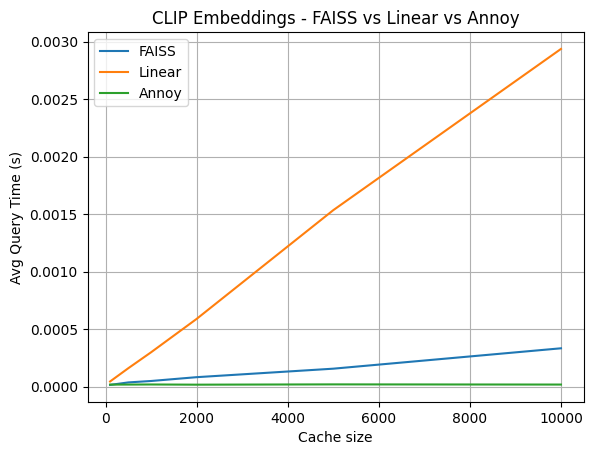

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from annoy import AnnoyIndex
from BaseCache import BaseSimilarityCache

# Config
DIMS = 512
CACHE_SIZES = [100, 500, 1000, 2000, 5000, 10000]
N_QUERIES = 100

def simulate_clip_embeddings(n: int) -> np.ndarray:
    vecs = np.random.randn(n, DIMS).astype(np.float32)
    return vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

def benchmark_linear_or_faiss(use_faiss: bool):
    avg_times = []
    for size in CACHE_SIZES:
        cache = BaseSimilarityCache(
            capacity=size,
            threshold=0.3,
            dim=DIMS,
            backend=use_faiss
        )
        embeddings = simulate_clip_embeddings(size)
        for i in range(size):
            cache.index.add(f"vec_{i}", embeddings[i])

        queries = simulate_clip_embeddings(N_QUERIES)
        start = time.time()
        for i, emb in enumerate(queries):
            cache.query(f"query_{i}", emb)
        end = time.time()

        avg_times.append((end - start) / N_QUERIES)
        print(f"{'FAISS' if use_faiss else 'Linear'} | Cache: {size} | Time/query: {avg_times[-1]:.6f}s")
    return avg_times

def benchmark_annoy():
    avg_times = []
    for size in CACHE_SIZES:
        index = AnnoyIndex(DIMS, 'angular')  # angular = cosine similarity on unit vectors
        embeddings = simulate_clip_embeddings(size)
        id_to_key = {}

        for i in range(size):
            index.add_item(i, embeddings[i])
            id_to_key[i] = f"vec_{i}"
        index.build(10)  # 10 trees is default balance between speed/accuracy

        queries = simulate_clip_embeddings(N_QUERIES)

        start = time.time()
        for emb in queries:
            index.get_nns_by_vector(emb, 1, include_distances=False)
        end = time.time()

        avg_times.append((end - start) / N_QUERIES)
        print(f"Annoy | Cache: {size} | Time/query: {avg_times[-1]:.6f}s")
    return avg_times

# Esegui benchmark
print("\n▶️ FAISS")
faiss_results = benchmark_linear_or_faiss(use_faiss=True)

print("\n▶️ Linear")
linear_results = benchmark_linear_or_faiss(use_faiss=False)

print("\n▶️ Annoy")
annoy_results = benchmark_annoy()

# Visualizzazione
plt.plot(CACHE_SIZES, faiss_results, label="FAISS")
plt.plot(CACHE_SIZES, linear_results, label="Linear")
plt.plot(CACHE_SIZES, annoy_results, label="Annoy")
plt.xlabel("Cache size")
plt.ylabel("Avg Query Time (s)")
plt.title("CLIP Embeddings - FAISS vs Linear vs Annoy")
plt.legend()
plt.grid(True)
plt.show()
